<a href="https://colab.research.google.com/github/drdww/OPIM5641/blob/main/Module6/M6_2/1_General_Framework_Regression_in_Pyomo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General Framework for Regression Problems in `Pyomo`
------------------------------------------
**OPIM 5641: Business Decision Modeling - University of Connecticut**

Let's use the pharmacy hours vs. revenue problem from Powell as our example. 


# Background
Regression models are optimization problems at heart - you are trying to optimize the selection of parameters (like $a$ and $b$) to minimize the errors (distance) between actual and predicted values.

Let's consider the pharmacy hours vs. revenue example.

## The Pharmacy Problem

A pharmacy has hired you to create a predictive model for determining, based on the number of hours that the pharmacy is open each week, the revenue.  Data from previous weeks is provided below:

Hours	| Revenue
---|---
	40	|5958
	44	| 6662
	48	| 6004
	48	| 6011
	60	|7250
	70	|8632
	72	|6964
	90	|11097
	100	|9107
	168	|11498

Can you build a model to predict revenue as a function of hours? Note that there are 168 hours in a week, so this is a store that is open 24/7 vs. the traditional 9 AM - 5 PM business hours.

In [ ]:
# these are the pharmacy hours

X = [
      40,
      44,
     48,
     48,
     60,
     70,
     72,
     90,
     100,
     168
]

# these are the revenue ($) from each corresponding store
Z = [
     5958,
     6662,
     6004,
     6011,
     7250,
     8632,
     6964,
     11097,
     9107,
     11498
]


Here's an example of the raw data.

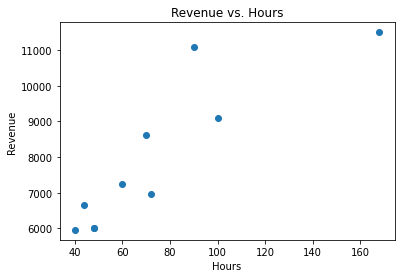

In [ ]:
import matplotlib.pyplot as plt # for plotting
from scipy import stats # for linear regression
import numpy as np

# we are going to use scipy, so it will be better to convert our lists into numpy arrays
XX = np.array(X)
ZZ = np.array(Z)

# plot the original data
plt.plot(XX, ZZ, 'o', label='original data')
plt.xlabel('Hours')
plt.ylabel('Revenue')
plt.title('Revenue vs. Hours')
plt.show()

# Types of Models

## Linear Model
Linear models have the form:

$Y = a + b  \times X$

Where $Y$ is the predicted value (predicted revenue), $a$ is the intercept and $b$ is the slope coefficient and $X$ is the raw data (hours). 

Although not in the equation let's think of $Z$ as the actual target variable (actual revenue).

Here it is with a linear regression fit to the data.

The optimal values for a and b are:
a: 4435.083751    b: 47.070490


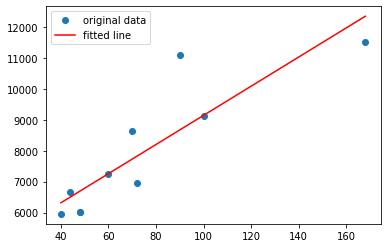

In [ ]:
import matplotlib.pyplot as plt # for plotting
from scipy import stats # for linear regression

# we are going to use scipy, so it will be better to convert our lists into numpy arrays
XX = np.array(X)
ZZ = np.array(Z)

# the values we care about are the first two returned by the function
b, a, r_value, p_value, std_err = stats.linregress(XX, ZZ) # (input data, target variable)
print('The optimal values for a and b are:')
print("a: %f    b: %f" % (a, b))

# first, let's plot the original data
plt.plot(XX, ZZ, 'o', label='original data')
# now, let's plot the line we got; note that we are using the linear regression expression as the second parameter of the plot function
plt.plot(XX, a + b*XX, 'r', label='fitted line')
plt.legend()
plt.show()

Linear regressions are very interpretable - a one unit increase in pharamcy hours would yield an increase of $47.07 in revenue.

## Power Model
$Y = a\times(X^b)$

This is just a twist on a linear model! By having $b$ as an exponent we are able add bends in the curve. 

A polynomial model is simply a combination of power models where $b$ is defined explicity... like this -

$Y = a_1\times(X^{b_1}) + a_2\times(X^{b_2}) + ... a_n\times(X^{b_n})$

Here is an example of square root curves. These are all $b = 1/2$ but $a$ is different.

<center>

![square root curves](https://dr282zn36sxxg.cloudfront.net/datastreams/f-d%3A5f257c32edf539c64f990fa0fe3e6184bd49ae1292dfba74e684cd03%2BIMAGE_TINY%2BIMAGE_TINY.1)

</center>

Alternatively, here is $x^2$, $x^3$ and $x^4$. This is why it's good to let the model determine what $b$ should be.

<center>

![x squared](https://mathonweb.com/help_ebook/html/functions_3/fungraph07.gif)

</center>

When we scroll up and look at the pharmacy problem, we see that some type of $a \times X^b$ model where $b = 0.5$ (a square root) will probably be a close fit! But we can use optimization to find the exact value.

# Minimize squared error (most common)
Regardless of either model you use, linear of power, your goal is to minimize the squared error.


$\min   \sum\limits_{i \in |X|}(y_i - z_i)^2$

The way you read this in plain language is to minimize the squared difference between predicted ($y$) and actual ($z$) values. Calculate for each row and then sum it up! If you have 10 observations in X, you will sum up 10 values.

What are the best values of the parameters $a$ and $b$ for this criterion? What is the minimum value of the objective function? 

# The Trick: Decision Variables, (*sneaky*) Constraints and tying it to the Objective Function
This is the biggest leaps for students to make. We need to be clever about how we use decision variables and constraints such that we can make a proper objective function.



## Decision Variables
We are going to declare decision variables for $a$ and $b$ of course - because these are the coefficients in our linear (or power) model.



```
model.a = Var(domain=Reals,initialize = 1)
model.b = Var(domain=Reals, initialize = 1)
```


And this is the hard part - you are also going to make a decision variable for each $y$ prediction.


```
# n_points is how many rows are in the spreadsheet
n_points = len(X)
# this make a decision variable for each y
model.y = Var([i for i in range(n_points)],domain=Reals)
```




Here's what this looks like when you pretty print.

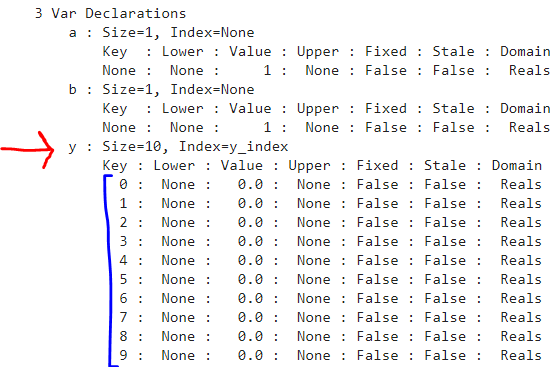

Now you have a decision variable for $a$, $b$ and $y$ (which has 10 decision variables underneath it - one for each row). So you can think of this as 3 or 12 decision variables...

## Constraints
This is where you will enforce the linear regression model! For each observation, you are going to say that $y$ must be equal to the linear regression.



```
# Constraints
model.constraints = ConstraintList()
# Predicted value
for i in range(n_points):
  x = X[i]
  model.constraints.add(model.y[i] == model.a + x*model.b)
```



What does this do? It makes ONE CONSTRAINT for each of your 10 $y$ values.

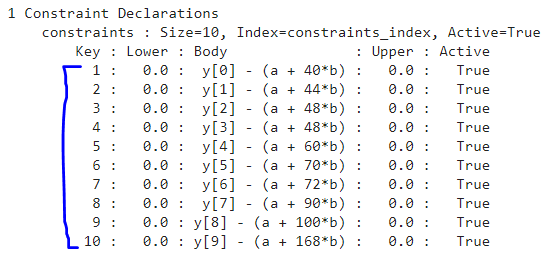

Do you see how Pyomo interpreted your constraint? It said that the predicted value [i] minus the linear regression model has to equal 0. This will force your prediction to be from a linear model! Note that $a$ and $b$ are fixed across ALL observations (they are all using the same $a$ and $b$).

## Objective Function
Now we can write an objective function, which is going to be a function of the actual ($z$) and predicted ($y$) values.

```
# declare objective
obj_expr = 0
for i in range(n_points):
  obj_expr += (model.y[i] - Z[i])**2
model.error = Objective(
                      expr = obj_expr,
                      sense = minimize)
```



This code yields the following output (you can scroll to the right).



```
1 Objective Declarations
    error : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : (y[0] - 5958)**2 + (y[1] - 6662)**2 + (y[2] - 6004)**2 + (y[3] - 6011)**2 + (y[4] - 7250)**2 + (y[5] - 8632)**2 + (y[6] - 6964)**2 + (y[7] - 11097)**2 + (y[8] - 9107)**2 + (y[9] - 11498)**2

```



The `+=` may be something that confuses you. That code is the same as this code:



```
# declare objective
obj_expr = 0
for i in range(n_points):
  obj_expr = obj_expr + (model.y[i] - Z[i])**2
model.error = Objective(
                      expr = obj_expr,
                      sense = minimize)
```



* At iteration 0, the `obj_expr` is updated to include the first error term 
  * `0 + (y[0] - 5958)**2`
    * Why 0? Because that's we intiliazed the variable as.
* At iteration 1, the `obj_expr` is updated to include the current value of obj_expr PLUS the next error term
  * `0 + (y[0] - 5958)**2 + (y[1] - 6662)**2`

Hence it just keeps building out the expression one section at a time, until the final formula is complete. Scroll up to see that full formula with 10 squared error equations in it.

## Tying it all together.

Your goal is to minimze the sum of these squared errors.

* you first made decision variables for $a$ and $b$
* then you made decision variables for each $y$ (10 of them, one for each row)
* then you made a constraint for each $y$ and forced it to take a linear form of the model
  * each $y$ is a function of $a$ and $b$
  * the $a$ and $b$ decision variables are constant across all observations
  * you could use linear, polynomial or power regression here
* then you used these $y$ predictions in your objective function which is just the sum of the squared errors between actual $z$ and predicted $y$
  * since $y$ is a function of $a$ and $b$, you can think of $a$ and $b$ being in the objective function (because each $y$ is made from $a$ and $b$)

# Solve!
You can look at the other script for how to solve and visualize the results. You are interested in the values of $a$, $b$ and the objective function (the sum of the errors - this is an error metric for how well your model fits the data).

# [advanced] Other Types of Error

## Absolute error
The math is simple... 

$\min   \sum\limits_{i \in |X|}|y_i - z_i|$

But the implementation DOES NOT WORK! You can't use `abs` in the code.


```
# declare objective
obj_expr = 0
for i in range(n_points):
  obj_expr += abs(model2.y[i] - Z[i])
model2.error = Objective(
                      expr = obj_expr,
                      sense = minimize)
```

But if you do... you get an error! 

### Why do I get an error? You can use the `abs()` in the objective function.

![absolute value function](https://upload.wikimedia.org/wikipedia/commons/thumb/6/6b/Absolute_value.svg/330px-Absolute_value.svg.png)

The absolute value function is continuous (i.e. it has no gaps). Remember that a derivative is the rate of change at any point - and smooth functions can be differentiated, but jagged/pointy functions cannot. The absolute value function is differentiable everywhere *except* at the point $x = 0$, where it makes a sharp turn as it crosses the y-axis. That sharp turn is a problem for calculating a derivative! 

[Read here](https://math.stackexchange.com/questions/991475/why-is-the-absolute-value-function-not-differentiable-at-x-0/991559) and [from here](https://en.wikipedia.org/wiki/Differentiable_function#:~:text=The%20absolute%20value%20function%20is,is%20continuous%20but%20not%20differentiable.) for a math explanation and an intuitive explanation.

## How do I use absolute error in the code?

You actually will make a DECISION VARIABLE for the absolute error - and you will subject it to two constraints.

```
# The following constrains enforce abs[i] >= |y[i] - z[i]|
# try the values y=14 and z=12 and see how the model would work
# then try the values y=10 and z=12 and see how the model would work
# since it is always [i] we overwrite the constraint if there's not a positive value!
for i in range(n_points):
  model2.constraints.add(model2.abs_value[i] >= model2.y[i] - Z[i])
  model2.constraints.add(model2.abs_value[i] >= -(model2.y[i] - Z[i]))

# Because we want to minimize the sum of absolute values, the solver will pick the smallest possible values of abs[i]. 
# Therefore, we will have abs[i] = |y[i] - z[i]|, as we wanted
obj_expr = 0
for i in range(n_points):
  obj_expr += model2.abs_value[i]
model2.error = Objective(
                      expr = obj_expr,
                      sense = minimize)
```




These two constraints actually look like this in the pretty print:

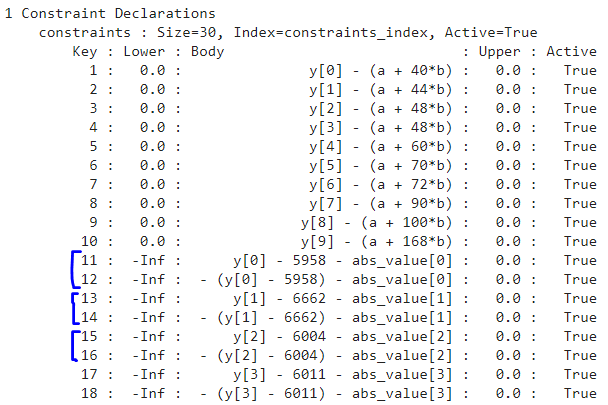

To recap, in addition to making decision variables for $a$ and $b$, you also made a decision variable for each $y$ and forced it to take on values in the model. You also have made a decision variable for each row for `abs_error` and invoked two constraints for each one. 

Regardless of whether you used a linear model or power model, by using this code for absolute error, you have also made a decision variable for each of the `abs_error` terms. 